In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import random
import math
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
print(device)

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [16]:
#################LOAD DATA############################
path = "C:/Users/Tony/Documents/TestData/data/"
dataset = pd.read_csv(path+"low_dataset.csv")

In [20]:
SOS_token = 0
EOS_token = 0

class Mydataset(Dataset):
    def __init__(self, inputs, targets):
        self.targets = targets
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def get_au_dictionary(dataframe):
    dic = {}
    groups = dataframe.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = dataframe.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        dic[key] = au
    return dic

def prepare_data(data, only_bs=True):
    ##pairs are same script name over n number of lines
    ##while name is not different, take the first 17 au columns, and the last 61 columns (ARKIT results) to form a pair
    ##return a list of pairs of dataframe
    pairs = []
    groups = data.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = data.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        bs = dt_indexed.iloc[:, -61:] #selects the last 61 columns corresponding to blendshapes + eyes rotation and head rotation in 3 axes (+ 9 variables) )
        if only_bs:
            bs = bs.iloc[:, :-9] #Drop the 9 columns not related to blendshapes (eyes + head rotation)
        length = au.shape[0]
        pairs.append((au, bs, length))
    return pairs

def sort_pairs(pairs):
    return [(inp, tgt, l) for inp, tgt, l in pairs if l < MAX_LENGTH ]
    

def my_collate_fn(batch):
    #sort batch in descending order
    #Batch is list of tuples
    inp = [x[0] for x in batch]
    tgt = [x[1] for x in batch]
    sorted_inp = sorted(inp, key=lambda x: x.shape[0], reverse=True)
    sorted_tgt = sorted(tgt, key=lambda x: x.shape[0], reverse=True)
    #get a list of each batch length
    lengths_of_batches = torch.LongTensor([x.shape[0] for x in sorted_inp])
    input_tensors = [torch.FloatTensor(inp).to(device) for inp in sorted_inp]
    target_tensors = [torch.FloatTensor(tgt).to(device) for tgt in sorted_tgt]
    padded_input = torch.nn.utils.rnn.pad_sequence(input_tensors)
    padded_target = torch.nn.utils.rnn.pad_sequence(target_tensors)
    return padded_input, padded_target, lengths_of_batches

#padded sequence
def get_dataloader(batch_size, data, train_data_percentage=0.7, test_data_percentage=0.2,short_sentences=False, only_bs=True):
    if train_data_percentage + test_data_percentage >= 1:
        print("train + test data_percentage must be lower than 1. You need room for the valid dataset")
        return
    pairs = prepare_data(data, only_bs=only_bs)
    if short_sentences:
        pairs = sort_pairs(pairs)
    inputs = [x[0].to_numpy() for x in pairs]
    targets = [x[1].to_numpy() for x in pairs]
    data = Mydataset(inputs, targets)
    generator = torch.Generator().manual_seed(42) #for reproductability
    train_size = int(train_data_percentage * len(data))
    test_size = int(test_data_percentage*len(data))
    val_size = int(len(data) - train_size - test_size)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, val_size, test_size], generator=generator)
    
    train_sampler = RandomSampler(train_dataset)
    test_sampler = RandomSampler(test_dataset)
    valid_sampler = RandomSampler(validation_dataset)

    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    validation_dataloader = DataLoader(validation_dataset, sampler=valid_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    return [train_dataloader, validation_dataloader, test_dataloader]


In [27]:
# ConvNet FROM : https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb

class Encoder(nn.Module):
    def __init__(self, 
                 input_dim,
                 emb_dim,
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.emb = nn.Linear(input_dim, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len, input_size]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        pos_embedded = self.pos_embedding(pos)
        
        #combine embeddings by elementwise summing
        embedded = (self.emb(src) + pos_embedded)
        conv_input = self.emb2hid(self.dropout(embedded))
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, src len, hid dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, hid dim]
        
        return conved, combined

In [29]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim,
                 emb_dim,
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.emb = nn.Linear(output_dim, emb_dim)

        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)


        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #combined = [batch size, trg len, hid dim]
        combined = (conved_emb + embedded) * self.scale
        #energy = [batch size, trg len, src len]
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))

        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
        attended_encoding = torch.matmul(attention, encoder_combined)
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        pos_embedded = self.pos_embedding(pos)

        embedded = (self.emb(trg)+pos_embedded)
        conv_input = self.emb2hid(self.dropout(embedded))
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [12]:
INPUT_DIM = 17
OUTPUT_DIM = 52
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = 0
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [24]:


def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        inpt, tgt, l = batch
        optimizer.zero_grad()

        output, _ = model(inpt.permute(1, 0, 2), tgt.permute(1, 0, 2))
        
        loss = criterion(output.view(-1), tgt.view(-1))
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            inp, tgt, l = batch
            output, _ = model(inp.permute(1, 0, 2), tgt.permute(1, 0, 2))
            loss = criterion(output.view(-1), tgt.view(-1))

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
batch_size = 4
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size, dataset)

In [31]:
train_loss_list = []
valid_loss_list = []
CUDA_LAUNCH_BLOCKING=1
for epoch in range(10):
    print("nb of batch", len(train_dataloader))
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, 1)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    end_time = time.time()
    
    print(f'Epoch: {epoch+1:02} | Time: {end_time - start_time}s')
    print(f'\tTrain Loss: {train_loss}')
    print(f'\t Val. Loss: {valid_loss}')


nb of batch 164


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


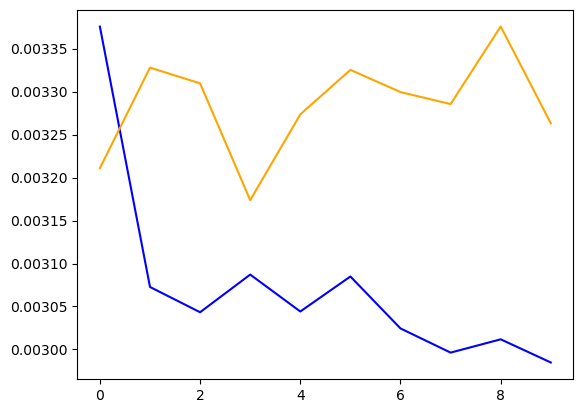

In [121]:
plt.plot(train_loss_list, color="blue")
plt.plot(valid_loss_list, color="orange")